In [1]:
import os
import logging

import pandas as pd
import tensorflow.keras as keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

# Log setting
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

# Change display.max_rows to show all features.
pd.set_option("display.max_rows", 85)

In [2]:
PROCESSED_DIR_PATH = r'C:\Users\mkahs\Repository\CICIDS\ProcessedDataset'
MODEL_DIR_PATH = r"C:\Users\mkahs\Repository\CICIDS\Model"

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler


def preprocessing(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    # Shuffle the dataset
    df = df.sample(frac=1)
    from sklearn.preprocessing import LabelEncoder
    target=df['Label'].values.tolist()
    label_encoder = LabelEncoder()
    y = np.array(label_encoder.fit_transform(target))


    # Split features and labels
    df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
    x = df.iloc[:, df.columns != 'Label']
      
#     y = df[['Label']].to_numpy()
    
#     x.drop('Label', axis=1, inplace=True)
#     np.any(np.isnan(x))
#     np.all(np.isfinite(x))
#     np.any(np.isnan(y))
#     np.all(np.isfinite(y))

    # Scale the features between 0 ~ 1
#     x = np.nan_to_num(x) 
#     y = np.nan_to_num(y) 
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    return x, y


def reshape_dataset_cnn(x: np.ndarray) -> np.ndarray:
    # Add padding columns
    result = np.zeros((x.shape[0], 81))
    result[:, :-3] = x

    # Reshaping dataset
    result = np.reshape(result, (result.shape[0], 9, 9))
    result = result[..., tf.newaxis]
    return result


def plot_history(history: tf.keras.callbacks.History):
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model2 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model2 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    logging.info('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

    # F1 score
    y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)

    logging.info("\n{}".format(classification_report(y_test, y_pred)))

In [21]:
def create_cnn_model() -> keras.Model:
    # Creating layers
    inputs = keras.layers.Input(shape=(9, 9, 1))
    x = keras.layers.Conv2D(120, 2, activation='relu', padding="same")(inputs)
    x = keras.layers.Conv2D(60, 3, activation='relu', padding="same")(x)
    x = keras.layers.Conv2D(30, 4, activation='relu', padding="same")(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    cnn_model = keras.Model(inputs=inputs, outputs=outputs, name='cnn')

    # Compile layers
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'],
                      optimizer='adam')

    return cnn_model

In [ ]:
# Create model
model = create_cnn_model()
logging.info(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 78)]              0         
                                                                 
 dense_2 (Dense)             (None, 128)               10112     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 15)                495       
                                                                 
Total params: 20,943
Trainable params: 20,943
Non-trainable params: 0
_________________________________________________________________


07:26:34 INFO None


In [6]:
# !pip install pydot

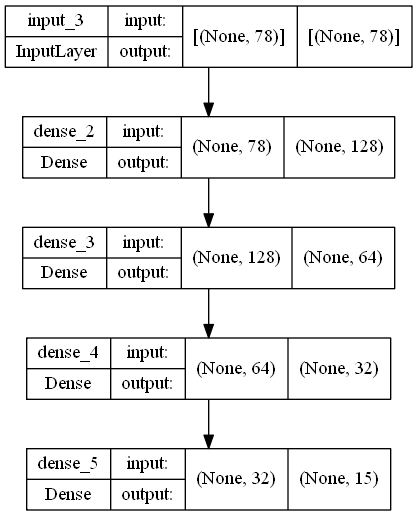

In [24]:
plot_model(model, show_shapes=True)

In [25]:
# Training
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'train_MachineLearningCVE.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

07:27:11 INFO Class distribution
BENIGN                      841966
DoS Hulk                     85292
PortScan                     59406
DDoS                         47205
DoS GoldenEye                 3759
FTP-Patator                   2910
SSH-Patator                   2214
DoS slowloris                 2182
DoS Slowhttptest              2034
Bot                            773
Web Attack-Brute Force         576
Web Attack-XSS                 234
Infiltration                    10
Web Attack-Sql Injection         7
Heartbleed                       7
Name: Label, dtype: int64


In [9]:
# print(df.shape)
# df.info()

In [10]:
# sfd

In [11]:
# np.any(np.isnan(mat))
# np.all(np.isfinite(mat))
X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)

In [12]:
Y

array([10,  0,  0, ...,  0,  4,  0], dtype=int64)

In [13]:
# from sklearn.preprocessing import LabelEncoder
# target=targets['YMode'].values.tolist()
# label_encoder = LabelEncoder()
# Y = np.array(label_encoder.fit_transform(target))

In [14]:
# Training
logging.info("*** TRAINING START ***")
history = model.fit(X, Y, validation_split=0.1, epochs=125, batch_size=1024, verbose=True)

06:33:48 INFO *** TRAINING START ***


Epoch 1/125
922/922 [==============================] - 32s 23ms/step - loss: 0.2029 - sparse_categorical_accuracy: 0.9327 - val_loss: 0.1114 - val_sparse_categorical_accuracy: 0.9509
Epoch 2/125
922/922 [==============================] - 21s 22ms/step - loss: 0.0810 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.0624 - val_sparse_categorical_accuracy: 0.9737
Epoch 3/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0559 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.0461 - val_sparse_categorical_accuracy: 0.9796
Epoch 4/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0457 - sparse_categorical_accuracy: 0.9806 - val_loss: 0.0432 - val_sparse_categorical_accuracy: 0.9828
Epoch 5/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0415 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.0395 - val_sparse_categorical_accuracy: 0.9834
Epoch 6/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0393 -

922/922 [==============================] - 20s 22ms/step - loss: 0.0091 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0097 - val_sparse_categorical_accuracy: 0.9974
Epoch 46/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0090 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0104 - val_sparse_categorical_accuracy: 0.9969
Epoch 47/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0089 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.0104 - val_sparse_categorical_accuracy: 0.9968
Epoch 48/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0087 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.0100 - val_sparse_categorical_accuracy: 0.9971
Epoch 49/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0086 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.0096 - val_sparse_categorical_accuracy: 0.9973
Epoch 50/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0087 - sparse

922/922 [==============================] - 20s 22ms/step - loss: 0.0069 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0088 - val_sparse_categorical_accuracy: 0.9977
Epoch 90/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0071 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0086 - val_sparse_categorical_accuracy: 0.9977
Epoch 91/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0069 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0095 - val_sparse_categorical_accuracy: 0.9973
Epoch 92/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0071 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0086 - val_sparse_categorical_accuracy: 0.9978
Epoch 93/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0070 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0087 - val_sparse_categorical_accuracy: 0.9975
Epoch 94/125
922/922 [==============================] - 20s 22ms/step - loss: 0.0070 - sparse

In [15]:
logging.info("*** TRAINING FINISH ***")
del X, Y

07:16:20 INFO *** TRAINING FINISH ***


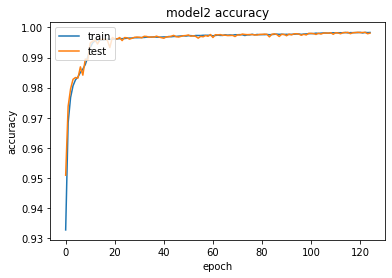

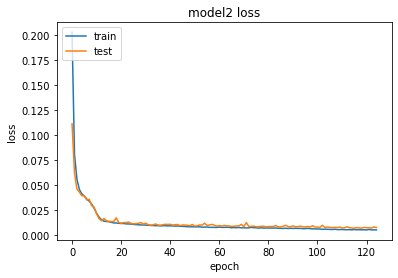

In [16]:
# Save the model
model.save(os.path.join(MODEL_DIR_PATH, "06_cnn.h5"))

plot_history(history)

In [17]:
# Evaluation
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'test_MachineLearningCVE.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

07:16:24 INFO Class distribution
BENIGN                      454406
DoS Hulk                     46081
PortScan                     31646
DDoS                         25802
DoS GoldenEye                 2009
FTP-Patator                   1593
SSH-Patator                   1190
DoS slowloris                 1163
DoS Slowhttptest              1129
Bot                            402
Web Attack-Brute Force         297
Web Attack-XSS                 145
Web Attack-Sql Injection         6
Infiltration                     6
Heartbleed                       2
Name: Label, dtype: int64


In [18]:
X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)

In [19]:
evaluation(model, X, Y)
del X, Y

07:17:11 INFO Evaluation:
Loss: 0.11034196615219116
Accuracy : 0.9687547087669373

07:17:15 INFO 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    454406
           1       0.29      0.39      0.34       402
           2       1.00      1.00      1.00     25802
           3       1.00      0.98      0.99      2009
           4       0.99      1.00      1.00     46081
           5       0.98      0.99      0.98      1129
           6       0.99      0.99      0.99      1163
           7       1.00      1.00      1.00      1593
           8       1.00      1.00      1.00         2
           9       1.00      0.67      0.80         6
          10       1.00      0.51      0.67     31646
          11       1.00      0.51      0.68      1190
          12       0.40      0.06      0.10       297
          13       0.00      0.00      0.00         6
          14       0.53      0.06      0.10       145

    accuracy                        

In [20]:
logging.info("*** END ***")

07:17:15 INFO *** END ***
